# Udacity SDC ND P4

### This notebook includes the analysis of the used algorithm on example image and the main pipeline to detect lane lines in the project video.

### For more please check the writeup_report.md and README.md files in same repo.

In [403]:
#importing libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle

# Load saved camera calibration data
calibr_data = pickle.load( open( "camera_calibration.pkl", "rb" ) )
mtx = calibr_data[0]
dist = calibr_data[1]

%matplotlib inline

### Used Functions

In [401]:
kernel_size = 5

# Undistort image
def undistort(img):
    ndist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return ndist_img

# Apply perspective transform
def warp(img,src,dst,img_size):
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped,M,Minv

# Convert image to thresholded HLS format

def hls_select(img, thresh):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


# Sobel filter
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    if orient == 'x':
        
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    else:
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))

        
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(binary) # Remove this line
    return binary_output


### Display example image from test_images folder and undistor it

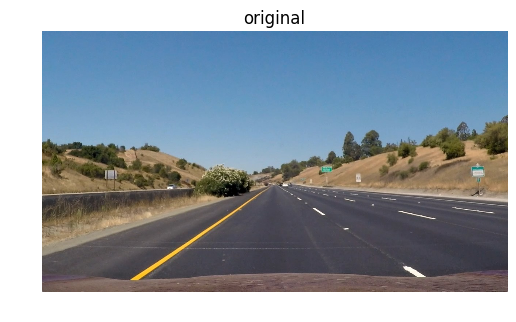

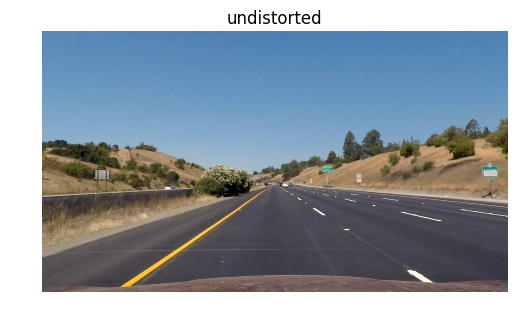

In [312]:
image = mpimg.imread('test_images/straight_lines1.jpg')
undistor_image = undistort(image)

# Display an save original and undistoted image to output_images folder
plt.imshow(image)
plt.axis('off');
plt.title('original')
plt.savefig("output_images/original_image.jpg")
plt.show()

plt.imshow(undistor_image)
plt.title('undistorted')
plt.axis('off');
plt.savefig("output_images/undistor_image.jpg")


## Perspective transform

In [313]:
img_size = np.shape(undistor_image)

# Choose the lower third part of the image
height_top = np.uint(img_size[0]* 2.0 /3.0)
height_bottom = np.uint(img_size[0])


# Source Points
top_left = np.uint(img_size[1]/2) - .2*np.uint(img_size[1]/2)
top_right = np.uint(img_size[1]/2) + .2*np.uint(img_size[1]/2)
bottom_left = np.uint(img_size[1]/2) - 0.9*np.uint(img_size[1]/2)
bottom_right =  np.uint(img_size[1]/2) + 0.9*np.uint(img_size[1]/2)

src = np.float32([[bottom_left,height_bottom],[bottom_right,height_bottom],[top_right,height_top],[top_left,height_top]])

# Destination points
dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],[img_size[1],0],[0,0]])

# Show source and destination points
print("Source Points:")
print(src)
print("Destination Points")
print(dst)

Source Points:
[[   64.   720.]
 [ 1216.   720.]
 [  768.   480.]
 [  512.   480.]]
Destination Points
[[    0.   720.]
 [ 1280.   720.]
 [ 1280.     0.]
 [    0.     0.]]


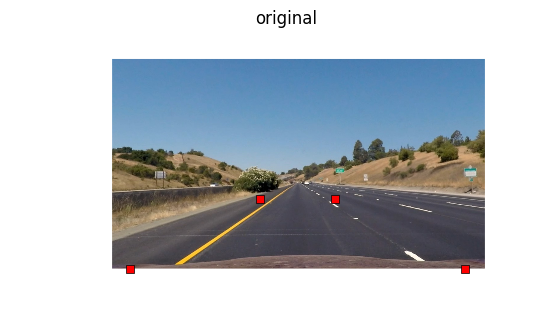

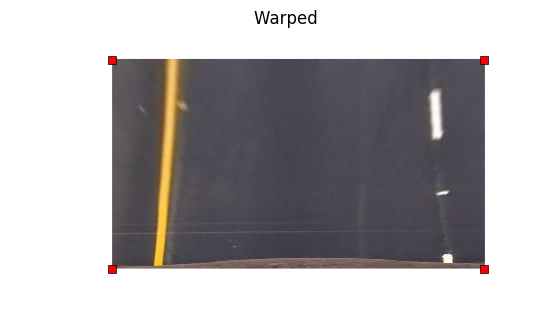

In [314]:
warped,M_warp,Minv_warp = warp(undistor_image,src,dst,(img_size[1],img_size[0]))


# Display original/warped images with source/destination points
plt.imshow(undistor_image)
for i in range(4):
    plt.plot(src[i][0],src[i][1],'rs')
plt.title('original')
plt.axis('off');
plt.savefig("output_images/perspective_source_points.jpg")
plt.show()

plt.imshow(warped)
for i in range(4):
    plt.plot(dst[i][0],dst[i][1],'rs')
plt.title('Warped')
plt.axis('off');
plt.savefig("output_images/perspective_transformed.jpg")
plt.show()



## Color Mask

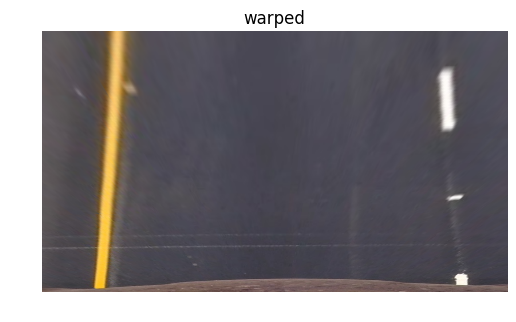

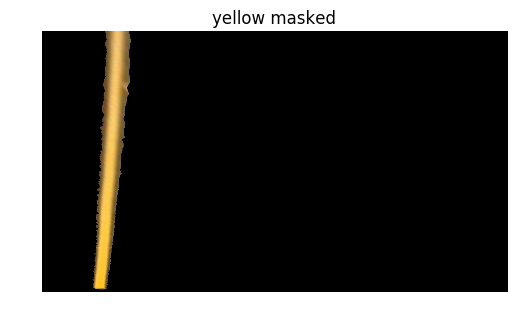

In [315]:
# Convert to HSV color space

HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

# Apply yellow color mask
yellow_mask = cv2.inRange(HSV, np.array([ 0,  100,  100]), np.array([ 80, 255, 255]))
yellow = cv2.bitwise_and(warped,warped, mask= yellow_mask)

# Display
plt.imshow(warped)
plt.axis('off');
plt.title('warped')
plt.show()
plt.imshow(yellow)
plt.title('yellow masked')
plt.axis('off');
plt.savefig("output_images/yellow_masked.jpg")


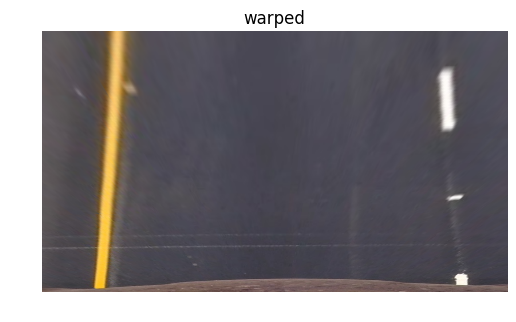

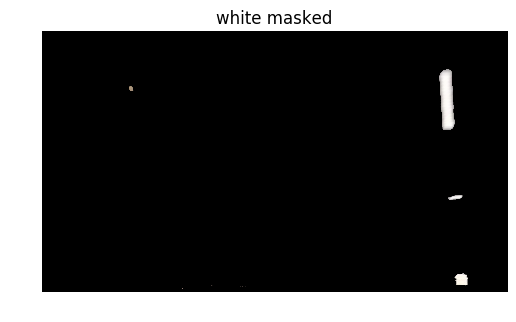

In [316]:
# Apply white color mask
white_mask = cv2.inRange(HSV, np.array([ 0,   0,   160]), np.array([ 255,  80, 255]))
white = cv2.bitwise_and(warped,warped, mask= white_mask)

# Display
plt.imshow(warped)
plt.axis('off');
plt.title('warped')
plt.show()
plt.imshow(white)
plt.title('white masked')
plt.axis('off');
plt.savefig("output_images/white_masked.jpg")


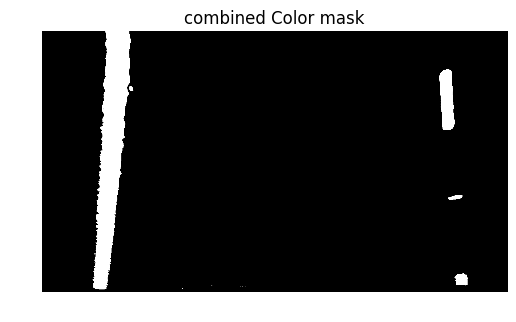

In [317]:
# Combine yellow and white colors
yellow_mask = cv2.inRange(HSV, np.array([ 0,  100,  100]), np.array([ 80, 255, 255]))
white_mask = cv2.inRange(HSV, np.array([ 0,   0,   160]), np.array([ 255,  80, 255]))
color_mask = cv2.bitwise_or(yellow_mask,white_mask)

# Display
plt.imshow(color_mask,cmap='gray')
plt.title('combined Color mask')
plt.axis('off');
plt.savefig("output_images/combined_color_masked.jpg")




## Sobel filters

### Apply Sobel filter for the S channel of the warped image in HLS channels space

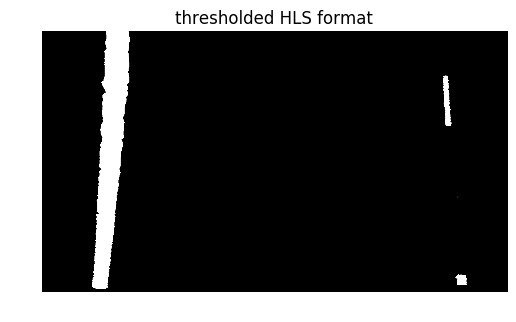

In [386]:
# Convert warped image to thresholded HLS format

HLS = hls_select(warped, thresh=(70, 255))

# Display
plt.imshow(HLS,cmap='gray')
plt.title('thresholded HLS format')
plt.axis('off');
plt.savefig("output_images/thresholded_HLS.jpg")




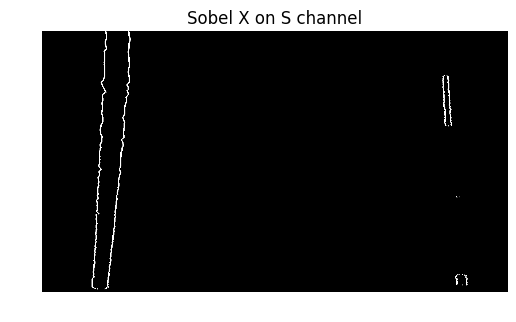

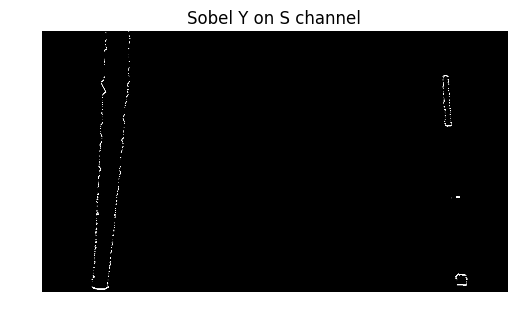

In [319]:
# Apply sobel filters
sobel_x = abs_sobel_thresh(HLS, orient='x', sobel_kernel=5, thresh=(50,255))
sobel_y = abs_sobel_thresh(HLS, orient='y', sobel_kernel=5, thresh=(50,255))

# Display
plt.imshow(sobel_x,cmap='gray')
plt.axis('off');
plt.title('Sobel X on S channel')
plt.savefig("output_images/sobel_x_on_s_channel.jpg")
plt.show()
plt.imshow(sobel_y,cmap='gray')
plt.title('Sobel Y on S channel')
plt.axis('off');
plt.savefig("output_images/sobel_y_on_s_channel.jpg")



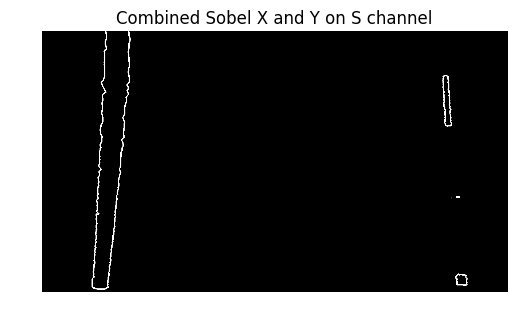

In [320]:
# Combile sobel filters
sobel = cv2.bitwise_or(sobel_x,sobel_y)

# Display
plt.imshow(sobel,cmap='gray')
plt.title('Combined Sobel X and Y on S channel')
plt.axis('off');
plt.savefig("output_images/combined_sobel.jpg")



## Combine color masks and sobel filters

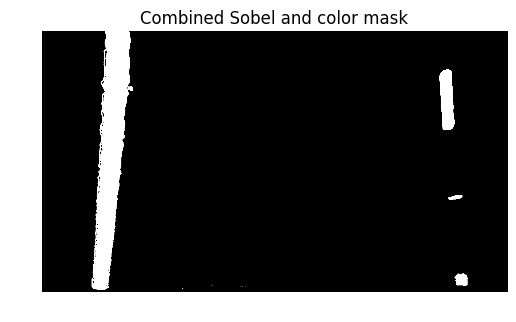

In [321]:
combined = np.zeros_like(sobel)
combined[(color_mask >=.5) | (sobel >=.5)] = 1

# Display
plt.imshow(combined,cmap='gray')
plt.title('Combined Sobel and color mask')
plt.axis('off');
plt.savefig("output_images/combined_sobel_color_mask.jpg")

plt.show()

## Locate Lanes

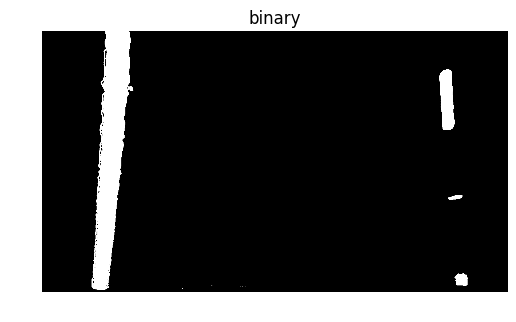

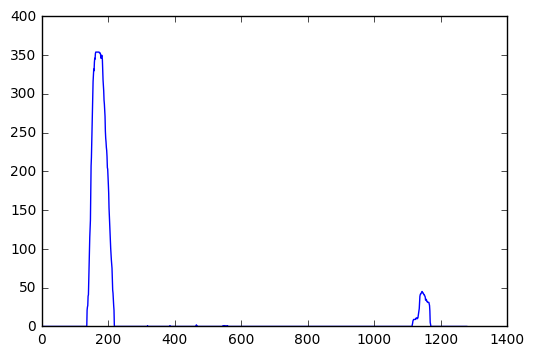

In [322]:
binary = np.zeros_like(combined)
binary[(combined > 0)] = 1


# compute histogram of distribution of pixel intensities
histogram = np.sum(binary[int(binary.shape[0]/2):,:], axis=0)

# Display
plt.imshow(binary,cmap='gray')
plt.title('binary')
plt.axis('off');
plt.show()

plt.plot(histogram)
plt.show()


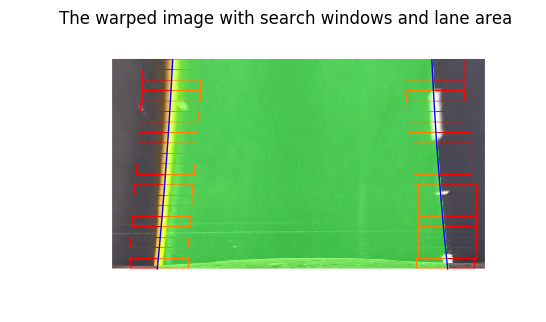

In [400]:
# Create an output image to draw on and  visualize the result
out_img = warped


# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 20


# Set height of windows
window_height = np.int(binary.shape[0]/nwindows)
minpix = 50

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []


for window in range(nwindows):
    
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary.shape[0] - (window+1)*window_height
    win_y_high = binary.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    

    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,0,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(255,0,0), 2)
    
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)


#Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


# Generate x and y values for plotting
ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx =right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Generate a polygon to fill the lane area
left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
lane_pts = np.hstack((left_line, right_line))
window_img = np.zeros_like(out_img)
cv2.fillPoly(window_img, np.int_([lane_pts]), (0,255, 0))

result = cv2.addWeighted(out_img, 1, window_img, 0.5, 0)



# Display the warped image with search windows and lane area
plt.imshow(result)
plt.plot(left_fitx, ploty, color='blue')
plt.plot(right_fitx, ploty, color='blue')
plt.title('The warped image with search windows and lane area')
plt.axis('off');
plt.savefig("output_images/lane_area.jpg")
plt.show()

## Draw the lanes back on the original image

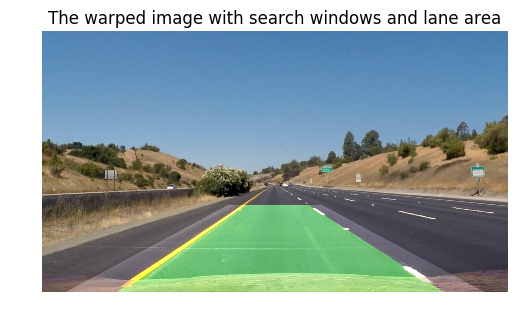

In [343]:
unwarp = cv2.warpPerspective(result, Minv_warp, (image.shape[1], image.shape[0])) 

result = cv2.addWeighted(image, 1, unwarp, 0.5, 0)

plt.imshow(result)
plt.title('The warped image with search windows and lane area')
plt.axis('off');
plt.savefig("output_images/lane_lines_area_original.jpg")
plt.show()


## Working on Project video

### Now we know where the lines are we have a fit! In the video frames we don't need to do a blind search again, but instead you can just search in a margin around the previous line position 

In [402]:
# Libraries needed to edit video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
pi = 3.14159

def process_frame(image):
    
    global left_fit
    global right_fit
    global bad_frame
    
    # Undistort image
    undistor_image = undistort(image)
    
    # Perspective transform
    warped,M_warp,Minv_warp = warp(undistor_image,src,dst,(img_size[1],img_size[0]))

    # Convert to HSV color space

    HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

    # Apply yellow color mask
    yellow_mask = cv2.inRange(HSV, np.array([ 0,  100,  100]), np.array([ 80, 255, 255]))
    yellow = cv2.bitwise_and(warped,warped, mask= yellow_mask)
    
    # Apply white color mask
    white_mask = cv2.inRange(HSV, np.array([ 0,   0,   160]), np.array([ 255,  80, 255]))
    white = cv2.bitwise_and(warped,warped, mask= white_mask)
    
    # Combine yellow and white colors
    yellow_mask = cv2.inRange(HSV, np.array([ 0,  100,  100]), np.array([ 80, 255, 255]))
    white_mask = cv2.inRange(HSV, np.array([ 0,   0,   160]), np.array([ 255,  80, 255]))
    color_mask = cv2.bitwise_or(yellow_mask,white_mask)
    
    # Convert warped image to thresholded HLS format
    HLS = hls_select(warped, thresh=(70, 255))
    
    # Apply sobel filters
    sobel_x = abs_sobel_thresh(HLS, orient='x', sobel_kernel=5, thresh=(50,255))
    sobel_y = abs_sobel_thresh(HLS, orient='y', sobel_kernel=5, thresh=(50,255))

    
    # Combine sobel filters
    sobel = cv2.bitwise_or(sobel_x,sobel_y)

    # Combine Color mask and sobel filters
    binary_warped = np.zeros_like(sobel)
    binary_warped[(color_mask >=.5) | (sobel >=.5)] = 1

    # Find lines pixels in a margin of 100
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    

    # Generate a polygon to fill the lane area
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_pts = np.hstack((left_line, right_line))
    window_img = np.zeros_like(out_img)
    cv2.fillPoly(window_img, np.int_([lane_pts]), (0,255, 0))

    result = cv2.addWeighted(out_img, 1, window_img, 0.7, 0)
   

    # Draw lane area and lines on the original image
    unwarp = cv2.warpPerspective(result, Minv_warp, (image.shape[1], image.shape[0])) 


    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)
    
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/350 # meters per pixel in x dimension
    
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    # calculate lane center and car offset
    
    #Compute intercepts
    left_intcpt = left_fit[0]*img_size[0]**2+left_fit[1]*img_size[0]+left_fit[2]
    right_intcpt = right_fit[0]*img_size[0]**2+right_fit[1]*img_size[0]+right_fit[2]
    
    # Compute center location
    lane_center = (left_intcpt+right_intcpt)/2.0
    
    ## Compute lane offset
    car_offset = lane_center - img_size[1]/2
    car_offset = np.round(car_offset/2.81362,2)
    
    
    # Write the the curvature of the lane and car position on the image
    font = cv2.FONT_HERSHEY_COMPLEX
    curve_text = 'Curvature: Right = ' + str(np.round(right_curverad,2)) + 'm, Left = ' + str(np.round(left_curverad,2)) + 'm' 
    car_offset_text = 'Car offset: ' + str(car_offset) + ' cm.'
    image = cv2.putText(image, curve_text, (30, 60), font, 1, (0,0,0), 2)
    image = cv2.putText(image, car_offset_text, (30, 90), font, 1, (0,0,0), 2)
    
    
    
    return (cv2.addWeighted(image, 1, unwarp, 0.7, 0))


In [393]:
# Apply on project video

project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4");
out_clip = clip1.fl_image(process_frame) 

%time out_clip.write_videofile(project_output, audio=False);

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:02<00:00,  7.27it/s]    | 1/1261 [00:00<02:56,  7.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 56s, sys: 2.95 s, total: 3min 59s
Wall time: 3min 3s
